# Import Libraries and Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import chardet

with open('/content/drive/MyDrive/Software Engineering/all-data.csv', 'rb') as f:
    result = chardet.detect(f.read())
print(result)

{'encoding': 'Windows-1252', 'confidence': 0.73, 'language': ''}


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Software Engineering/all-data.csv',encoding='Windows-1252',header=None)
df.columns = ['Sentiment', 'News Headline']
df.head()

,Sentiment,News Headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


# Data Understanding

About Dataset: <br><br>

This dataset contains the sentiments for financial news headlines from the perspective of a retail investor. Further details about the dataset can be found in: Malo, P., Sinha, A., Takala, P., Korhonen, P. and Wallenius, J. (2014): “Good debt or bad debt: Detecting semantic orientations in economic texts.” Journal of the American Society for Information Science and Technology.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Sentiment      4846 non-null   object
 1   News Headline  4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [ ]:
df.describe()

,Sentiment,News Headline
count,4846,4846
unique,3,4838
top,neutral,TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...
freq,2879,2


In [ ]:
df.shape

(4846, 2)

In [ ]:
df.isnull().sum()

,0
Sentiment,0
News Headline,0


In [ ]:
df.rename(columns={"Sentiment": "Label", "News Headline": "Headline"}, inplace=True)

# Encode sentiment labels
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df['Label'] = df['Label'].map(label_mapping)

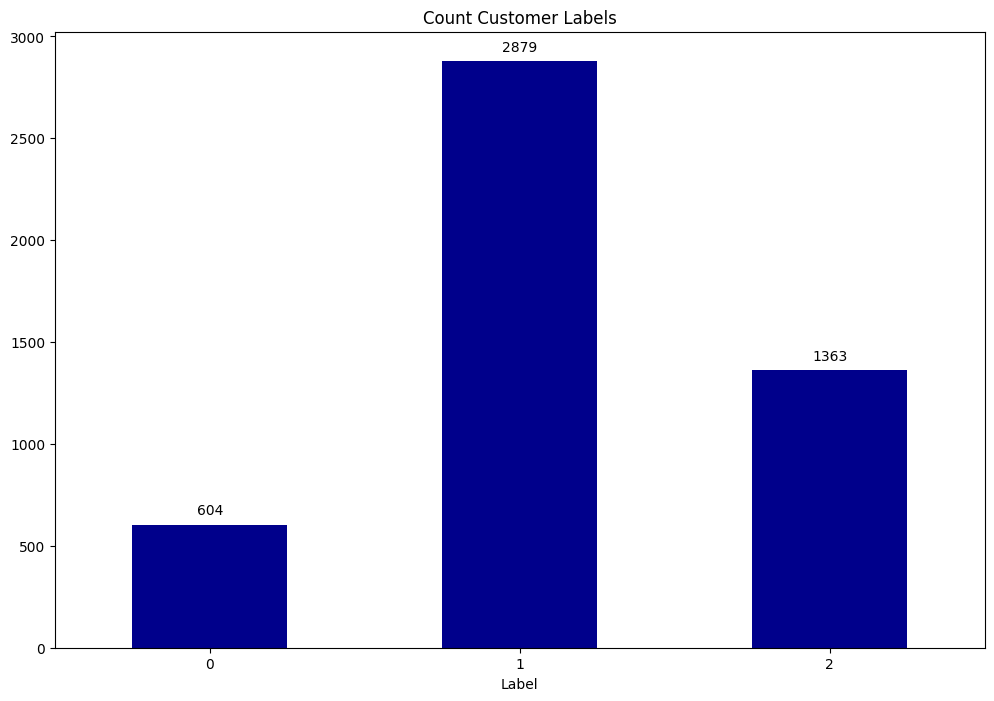

In [ ]:
ax = df['Label'].value_counts().sort_index().plot(kind='bar',title='Count Customer Labels',figsize=(12,8), color='darkblue')
ax.set_xlabel('Label')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Add numbers above the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points')

plt.show()

Because the labels is not balanced we can use oversampling on this labels

In [ ]:
df = df[['Headline','Label']]

# Data Cleaning

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

# Clean text
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['Headline'] = df['Headline'].apply(clean_text)

# Splitting data

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Headline'], df['Label'], test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
max_vocab_size = 20000
max_sequence_length = 100

tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')

# Handle Imbalanced class

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_padded, y_train)

# Check class distributions
print("Original class distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Balanced class distribution:", dict(zip(*np.unique(y_train_balanced, return_counts=True))))

Original class distribution: {0: 494, 1: 2308, 2: 1074}
Balanced class distribution: {0: 2308, 1: 2308, 2: 2308}


# Models

## LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

embedding_dim = 128  # Increased embedding dimensions
learning_rate = 0.001

# Improved Model
model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(128, return_sequences=True)),  # Bidirectional LSTM
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),  # Fully connected layer for intermediate features
    Dropout(0.3),
    Dense(3, activation='softmax')  # Output layer for 3 classes
])

# Compile the model with Adam optimizer
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2
                              , min_lr=1e-6)

# Train the model
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_test_padded, y_test),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## LLM

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset
import torch
from sklearn.metrics import classification_report

In [ ]:
# Split the dataset into train, validation, and test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['Headline'], df['Label'], test_size=0.2, random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    test_texts, test_labels, test_size=0.5, random_state=42)

In [ ]:
# Load tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize datasets
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

# Convert to Hugging Face Dataset format
def encode_dataset(encodings, labels):
    return Dataset.from_dict({key: encodings[key] for key in encodings.keys()} | {"labels": labels})

train_dataset = encode_dataset(train_encodings, list(train_labels))
val_dataset = encode_dataset(val_encodings, list(val_labels))
test_dataset = encode_dataset(test_encodings, list(test_labels))

# Compute class weights
labels_array = np.array(train_labels)
class_weights = compute_class_weight("balanced", classes=np.unique(labels_array), y=labels_array)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Load pre-trained model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3
)

# Adjust the loss function to include class weights
class WeightedLossModel(torch.nn.Module):
    def __init__(self, base_model, class_weights):
        super(WeightedLossModel, self).__init__()
        self.base_model = base_model
        self.class_weights = class_weights

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        if labels is not None:  # Apply class weights if labels are provided
            loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fn(logits, labels)
        return {"loss": loss, "logits": logits}

weighted_model = WeightedLossModel(model, class_weights_tensor)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import numpy as np

# Define a function to compute evaluation metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)  # Get predicted class indices
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=0)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# Training arguments with early stopping
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # Use validation loss to select the best model
    greater_is_better=False,  # Smaller validation loss is better
)

# Define Trainer with early stopping
trainer = Trainer(
    model=weighted_model,  # Model with class weights
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # Add custom metrics
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Early stopping after 3 epochs without improvement
)

# Train the model
trainer.train()

# Evaluate on test set
print("Evaluating on Test Set:")
predictions = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)  # Get predicted labels
print("Classification Report:")
print(classification_report(test_labels, predicted_labels, digits=4))  # Detailed metrics report

<ipython-input-54-93d4a03630ca>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.085600,1.514555,0.806186,0.803356,0.806186,0.803995
2,0.102300,1.663375,0.812371,0.809631,0.812371,0.808620
3,0.000400,1.581274,0.820619,0.818898,0.820619,0.819480


Evaluating on Test Set:


Classification Report:
              precision    recall  f1-score   support

           0     0.8333    0.8036    0.8182        56
           1     0.8571    0.8842    0.8705       285
           2     0.7664    0.7292    0.7473       144

    accuracy                         0.8289       485
   macro avg     0.8190    0.8056    0.8120       485
weighted avg     0.8275    0.8289    0.8279       485



In [ ]:
# Evaluate on the test set (round to 2 decimal values)
predictions = trainer.predict(test_dataset)
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1)

# Classification report
print("Classification Report:")
print(classification_report(list(test_labels), predicted_labels.numpy()))

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82        56
           1       0.86      0.88      0.87       285
           2       0.77      0.73      0.75       144

    accuracy                           0.83       485
   macro avg       0.82      0.81      0.81       485
weighted avg       0.83      0.83      0.83       485



In [ ]:
from torchinfo import summary
import torch

# Move the model to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
weighted_model.base_model.to(device)

# Create a dummy input tensor on the same device as the model
dummy_input = torch.randint(0, 30522, (16, 128), dtype=torch.long).to(device)  # (batch_size, sequence_length)

# Display model architecture with proper input type and device
print("Detailed Model Summary:")
summary(weighted_model.base_model, input_data=dummy_input, col_names=["output_size", "num_params"])

Detailed Model Summary:


Layer (type:depth-idx)                                  Output Shape              Param #
DistilBertForSequenceClassification                     [16, 3]                   --
├─DistilBertModel: 1-1                                  [16, 128, 768]            --
│    └─Embeddings: 2-1                                  [16, 128, 768]            --
│    │    └─Embedding: 3-1                              [16, 128, 768]            23,440,896
│    │    └─Embedding: 3-2                              [1, 128, 768]             393,216
│    │    └─LayerNorm: 3-3                              [16, 128, 768]            1,536
│    │    └─Dropout: 3-4                                [16, 128, 768]            --
│    └─Transformer: 2-2                                 [16, 128, 768]            --
│    │    └─ModuleList: 3-5                             --                        42,527,232
├─Linear: 1-2                                           [16, 768]                 590,592
├─Dropout: 1-3                 

# Conclusion

Based on the validation loss metrics, the **LSTM model tends to overfitting** because different techniques used in balancing class.<br><br>

For the LSTM model, we use **oversampling techniques** to hanlde imbalanced class and for LLM model, we use **weighting techniques** to handle imbalanced class. <br><br>

For accuracy metrics, Distilbert model (LLM) provide better value. Therefore, we will take **Distilbert** model as our final model because LLM model tends to handle context more clearly and better than the Deep Learning models

# Save and load the model in pytorch file

In [ ]:
import torch

# Save the model
torch.save(weighted_model.state_dict(), "trained_llm_model.pt")
print("Model weights saved to 'trained_llm_model.pt'.")

# Save tokenizer
tokenizer.save_pretrained("tokenizer/")
print("Tokenizer saved to 'tokenizer/'.")

# Save to pickle format if required
import pickle

# Save a metadata dictionary (e.g., class mappings, other configurations)
metadata = {
    "model_name": "distilbert-base-uncased",
    "class_labels": {0: "Negative", 1: "Neutral", 2: "Positive"},
}
with open("model_metadata.pkl", "wb") as metadata_file:
    pickle.dump(metadata, metadata_file)
print("Metadata saved to 'model_metadata.pkl'.")

Model weights saved to 'trained_llm_model.pt'.
Tokenizer saved to 'tokenizer/'.
Metadata saved to 'model_metadata.pkl'.


In [ ]:
# Code for load the model:

# # Load model weights
# from transformers import AutoModelForSequenceClassification

# model_name = "distilbert-base-uncased"
# loaded_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
# loaded_model.load_state_dict(torch.load("trained_llm_model.pt"))
# print("Model weights loaded from 'trained_llm_model.pt'.")

# # Load tokenizer
# from transformers import AutoTokenizer

# loaded_tokenizer = AutoTokenizer.from_pretrained("tokenizer/")
# print("Tokenizer loaded from 'tokenizer/'.")

# # Load metadata
# with open("model_metadata.pkl", "rb") as metadata_file:
#     loaded_metadata = pickle.load(metadata_file)
# print("Metadata loaded:", loaded_metadata)